In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

In [2]:
def f(x, y, z, w):
    return -x**4+200*x+y**4-200*y-z**4+200*z-w**4+200*w

num_of_samples = 20
x_data = np.float64(np.linspace(-5, 5, num_of_samples))
y_data = np.float64(np.linspace(-5, 5, num_of_samples))
z_data = np.float64(np.linspace(-5, 5, num_of_samples))
w_data = np.float64(np.linspace(-5, 5, num_of_samples))

X, Y, Z, W = np.meshgrid(x_data, y_data, z_data, w_data)
outs = f(X, Y, Z, W)

In [3]:
dataset = Dataset(np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1), W.reshape(-1, 1)), axis=1), outs.reshape(-1, 1))

intersize, testsize = 70, 100
interset, trainset, testset = torch.utils.data.random_split(dataset, [intersize, len(dataset)-intersize-testsize, testsize], generator=torch.Generator().manual_seed(42)) # 0.1=3000

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

activation = nn.Sigmoid()

In [4]:
class ELM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = activation(x)
        x = self.fc2(x)
        return x

model = ELM(4, 100, 1)

In [5]:
V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ interset[:][0].T)
H = torch.concatenate([torch.ones(1, len(interset)), V], dim=0).T
T = interset[:][1].reshape(1, -1).T
W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-10)

Epoch: [1/10], loss: 54420.833791
Epoch: [2/10], loss: 30149.621514
Epoch: [3/10], loss: 27760.898665
Epoch: [4/10], loss: 41642.062376
Epoch: [5/10], loss: 32200.437553
Epoch: [6/10], loss: 36893.738343
Epoch: [7/10], loss: 45756.698339
Epoch: [8/10], loss: 43819.075894
Epoch: [9/10], loss: 26970.660710
Epoch: [10/10], loss: 30157.800193


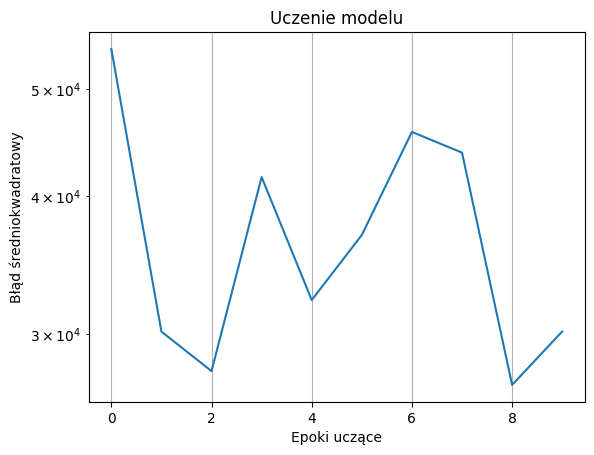

In [7]:
num_epochs = 10
all_losses = []
model.train()

for epoch in range(num_epochs):
    for i, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        x, y = x.reshape(-1, 4), y.reshape(-1, 1)
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
    all_losses.append(loss.item())
    print(f'Epoch: [{epoch+1}/{num_epochs}], loss: {loss.item():.6f}')

plt.plot(all_losses)
# plt.yscale('log')
plt.title('Uczenie modelu')
plt.xlabel('Epoki uczące')
plt.ylabel('Błąd średniokwadratowy')
plt.grid()
plt.show()

Train error: 34689.51563200868
Test error: 31281.29559196696


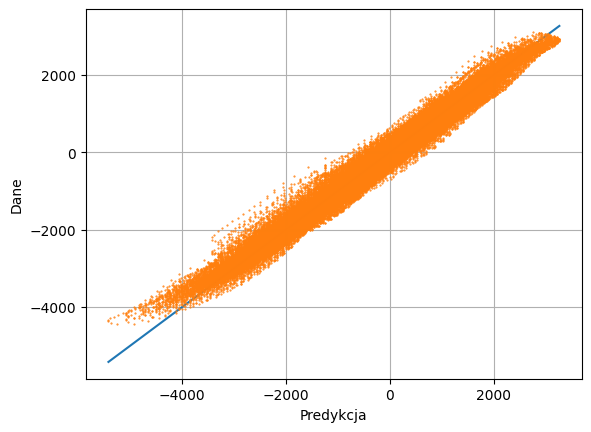

In [8]:
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 4))-trainset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 4))-testset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
plt.plot([np.min(outs), np.max(outs)], [np.min(outs), np.max(outs)])
plt.plot(outs.reshape(-1), model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1), torch.Tensor(Z).reshape(-1, 1), torch.Tensor(W).reshape(-1, 1)), axis=1)).detach().numpy().reshape(-1), '.', markersize=1)
plt.xlabel('Predykcja')
plt.ylabel('Dane')
plt.grid()
plt.show()